In [29]:
!pip install adversarial-robustness-toolbox

In [30]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


In [31]:
import cv2
import os
import torch
import random
import pickle
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications import ResNet50
from keras.applications import VGG16
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.models import load_model, save_model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape, Lambda
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
%matplotlib inline

In [32]:
%cd $path

/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


In [33]:
data_path = path
train_data_path = os.path.join(data_path, 'Train')
test_data_path = os.path.join(data_path, 'Test')
meta_data_path = os.path.join(data_path, 'Meta')

data[0]:
 [[[0.47058824 0.49019608 0.5058824 ]
  [0.47058824 0.47843137 0.49803922]
  [0.4862745  0.4862745  0.5058824 ]
  ...
  [0.46666667 0.47058824 0.47843137]
  [0.4627451  0.46666667 0.45882353]
  [0.45490196 0.4627451  0.46666667]]

 [[0.4862745  0.49803922 0.50980395]
  [0.48235294 0.49019608 0.5019608 ]
  [0.47843137 0.48235294 0.5019608 ]
  ...
  [0.49019608 0.49411765 0.5137255 ]
  [0.4745098  0.47058824 0.4627451 ]
  [0.46666667 0.4509804  0.45490196]]

 [[0.49411765 0.5019608  0.5411765 ]
  [0.49803922 0.5058824  0.54901963]
  [0.4862745  0.49803922 0.54509807]
  ...
  [0.6039216  0.60784316 0.6313726 ]
  [0.5411765  0.52156866 0.5372549 ]
  [0.53333336 0.49019608 0.50980395]]

 ...

 [[0.34117648 0.36078432 0.3647059 ]
  [0.34901962 0.36078432 0.36078432]
  [0.3529412  0.35686275 0.36078432]
  ...
  [0.39607844 0.42745098 0.4509804 ]
  [0.36862746 0.3882353  0.4       ]
  [0.37254903 0.38431373 0.3882353 ]]

 [[0.33333334 0.34117648 0.34901962]
  [0.34117648 0.34901962 0.

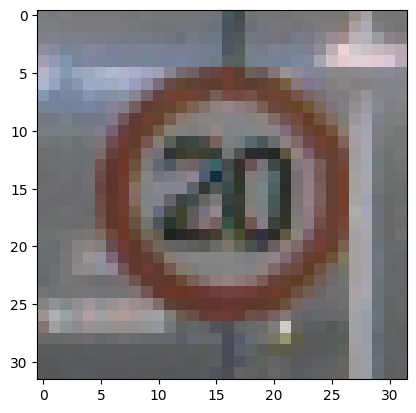

In [34]:
# предобработка
data = []
labels = []
class_count = 43
for i in range(class_count):
    img_path = os.path.join(train_data_path, str(i))
    for img in os.listdir(img_path):
        img = image.load_img(img_path + '/' + img, target_size=(32, 32))
        img_array = image.img_to_array(img)
        img_array = img_array / 255
        data.append(img_array)
        labels.append(i)
data = np.array(data)
labels = np.array(labels)
labels = to_categorical(labels, 43)
# отобразим первый элемент
print("data[0]:\n",data[0])
# отобразим первый элемент в виде картинки
plt.imshow(data[0])

In [35]:
# Разделение данных
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.3, random_state=1)

print(f"Размер тренировочного набора: {x_train.shape}, {y_train.shape}")
print(f"Размер валидационного набора: {x_val.shape}, {y_val.shape}")

Размер тренировочного набора: (27446, 32, 32, 3), (27446, 43)
Размер валидационного набора: (11763, 32, 32, 3), (11763, 43)


In [36]:
model = Sequential()
model.add(ResNet50(include_top = False, pooling = 'avg'))
model.add(Dropout(0.1))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(43, activation = 'softmax'))
model.layers[2].trainable = False
# отобразим итоговую сводку по модели
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,123,307 (92.02 MB)

 Trainable params: 23,545,643 (89.82 MB)

 Non-trainable params: 577,664 (2.20 MB)

None


In [37]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
# сохраним историю обучения для последующего анализа на графиках
history = model.fit(x_train, y_train, validation_data =(x_val, y_val), epochs = 5, batch_size = 64)

Epoch 1/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 89s 96ms/step - accuracy: 0.5543 - loss: 1.7666 - val_accuracy: 0.1586 - val_loss: 3.2757
Epoch 2/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - accuracy: 0.9348 - loss: 0.2598 - val_accuracy: 0.7454 - val_loss: 1.0856
Epoch 3/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.9641 - loss: 0.1280 - val_accuracy: 0.9598 - val_loss: 0.1513
Epoch 4/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9698 - loss: 0.1115 - val_accuracy: 0.9120 - val_loss: 0.5201
Epoch 5/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.9746 - loss: 0.0903 - val_accuracy: 0.9725 - val_loss: 0.1594


In [38]:
save_model(model, 'ResNet50.h5')

In [39]:
test = pd.read_csv("Test.csv")
test_imgs = test['Path'].values
data = []

for img in test_imgs:
    img = image.load_img(img, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = img_array / 255
    data.append(img_array)

data = np.array(data)
y_test = test['ClassId'].values.tolist()
y_test = np.array(y_test)
y_test = to_categorical(y_test, 43)

In [40]:
model2 = Sequential()
model2.add(VGG16(include_top=False, pooling = 'avg'))
model2.add(Dropout(0.1))
model2.add(Dense(256, activation="relu"))
model2.add(Dropout(0.1))
model2.add(Dense(43, activation = 'softmax'))
model2.layers[2].trainable = False
# отобразим итоговую сводку по модели
print(model2.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 512)                 │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,857,067 (56.68 MB)

 Trainable params: 14,725,739 (56.17 MB)

 Non-trainable params: 131,328 (513.00 KB)

None


 Обучение моделей VGG16 и ResNet50 на наборе данных GTSRB

In [41]:
model2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
# сохраним историю обучения для последующего анализа на графиках
history2 = model2.fit(x_train, y_train, validation_data =(x_val, y_val), epochs = 5, batch_size = 64)

Epoch 1/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 30s 57ms/step - accuracy: 0.1177 - loss: 3.2457 - val_accuracy: 0.5637 - val_loss: 1.3097
Epoch 2/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.6396 - loss: 1.0450 - val_accuracy: 0.8507 - val_loss: 0.4172
Epoch 3/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.8469 - loss: 0.4580 - val_accuracy: 0.9390 - val_loss: 0.1956
Epoch 4/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9467 - loss: 0.1828 - val_accuracy: 0.9791 - val_loss: 0.0933
Epoch 5/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9705 - loss: 0.1187 - val_accuracy: 0.9793 - val_loss: 0.0787


In [42]:
save_model(model2, 'VGG16.h5')

 Реализация FGSM и PGD атак

In [43]:
history_test = model.fit(x_val, y_val, epochs=5, batch_size=64, validation_data=(x_val, y_val))
history2_test = model2.fit(x_val, y_val, epochs=5, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 27s 146ms/step - accuracy: 0.9706 - loss: 0.1169 - val_accuracy: 0.9832 - val_loss: 0.0601
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - accuracy: 0.9800 - loss: 0.0810 - val_accuracy: 0.9897 - val_loss: 0.0327
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9899 - loss: 0.0365 - val_accuracy: 0.9820 - val_loss: 0.0648
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9846 - loss: 0.0583 - val_accuracy: 0.9694 - val_loss: 0.1006
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.9844 - loss: 0.0496 - val_accuracy: 0.9865 - val_loss: 0.0516
Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.9733 - loss: 0.1093 - val_accuracy: 0.9737 - val_loss: 0.0968
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.9632 - loss: 0.1537 - val_accuracy: 0.9855 - val_loss: 0.0637
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9590 - loss: 0.2071 - val_accura

Реализация целевой атаки уклонения на знак «Стоп»

In [44]:
from tabulate import tabulate

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
test_accuracy = history_test.history['accuracy']

train_accuracy2 = history2_test.history['accuracy']
val_accuracy2 = history2_test.history['val_accuracy']
test_accuracy2 = history2_test.history['accuracy']

table = [["Model","Training Accuracy","Validation Accuracy","Test Accuracy"],
            ["Resnet50",train_accuracy[4]*100,val_accuracy[4]*100,test_accuracy[4]*100],
            ["VGG16",train_accuracy2[4]*100,val_accuracy2[4]*100,test_accuracy2[4]*100]]

table1 = tabulate(table,headers="firstrow",tablefmt="grid")
print(table1)


+----------+---------------------+-----------------------+-----------------+
| Model    |   Training Accuracy |   Validation Accuracy |   Test Accuracy |
+==========+=====================+=======================+=================+
| Resnet50 |             97.6973 |               97.2456 |         98.4613 |
+----------+---------------------+-----------------------+-----------------+
| VGG16    |             98.4868 |               99.3199 |         98.4868 |
+----------+---------------------+-----------------------+-----------------+


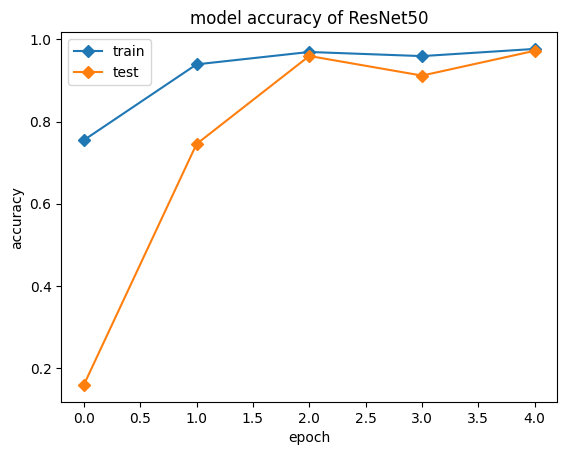

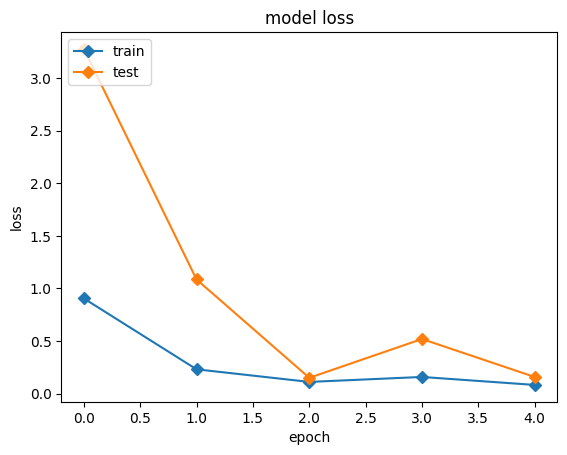

In [45]:
# график точности
plt.plot(history.history['accuracy'], marker='D')
plt.plot(history.history['val_accuracy'], marker='D')
plt.title('model accuracy of ResNet50')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# график потерь
plt.plot(history.history['loss'], marker='D')
plt.plot(history.history['val_loss'], marker='D')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

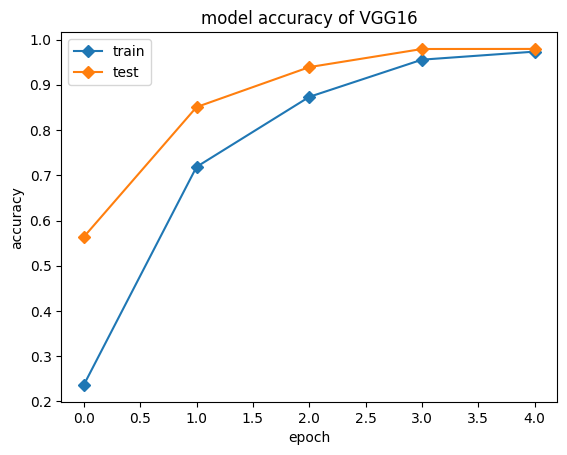

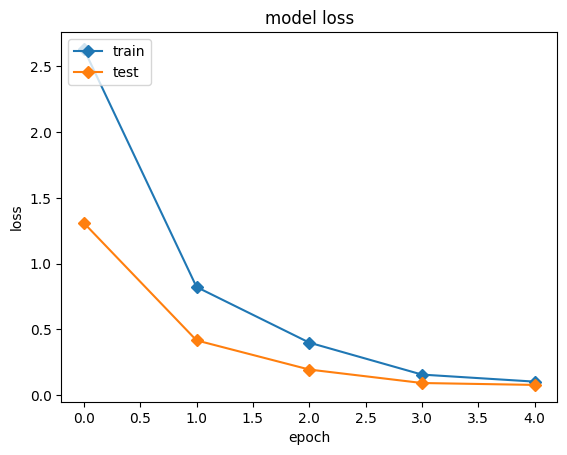

In [46]:
# график точности
plt.plot(history2.history['accuracy'], marker='D')
plt.plot(history2.history['val_accuracy'], marker='D')
plt.title('model accuracy of VGG16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# график потерь
plt.plot(history2.history['loss'], marker='D')
plt.plot(history2.history['val_loss'], marker='D')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
from art.estimators.classification import TensorFlowV2Classifier

In [48]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model=load_model('ResNet50.h5')
x_test = data[:1000]
y_test = y_test[:1000]
nb_classes = 1000
input_shape = (224, 224, 3)
classifier = TensorFlowV2Classifier(model=model, nb_classes=nb_classes, input_shape=input_shape, clip_values=(np.min(x_test), np.max(x_test)), loss_object=loss_object)

Атака FGSM на ResNet50

In [49]:
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.3)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_fgsm = []
true_losses = []
adv_losses_fgsm = []
for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_fgsm.append(accuracy)
    adv_losses_fgsm.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")


Eps: 0.00392156862745098
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7800 - loss: 1.3394
Adv Loss: 1.3245621919631958
Adv Accuracy: 0.7680000066757202
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9039 - loss: 0.3704
True Loss: 0.37217968702316284
True Accuracy: 0.9070000052452087
Eps: 0.00784313725490196
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6289 - loss: 2.3757
Adv Loss: 2.4267895221710205
Adv Accuracy: 0.6119999885559082
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9039 - loss: 0.3704
True Loss: 0.37217968702316284
True Accuracy: 0.9070000052452087
Eps: 0.011764705882352941
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5240 - loss: 3.2436
Adv Loss: 3.335953712463379
Adv Accuracy: 0.5040000081062317
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9039 - loss: 0.3704
True Loss: 0.37217968702316284
True Accuracy: 0.9070000052452087
Eps: 0.01568627450980392
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4645 - loss: 3.9206
Adv 

Сохраняем результаты

In [50]:
adv_losses_fgsm = np.array(adv_losses_fgsm)
adv_accuracises_fgsm = np.array(adv_accuracises_fgsm)
np.save("adv_losses_fgsm_ResNet50", adv_losses_fgsm)
np.save("adv_accuracises_fgsm_ResNet50", adv_accuracises_fgsm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


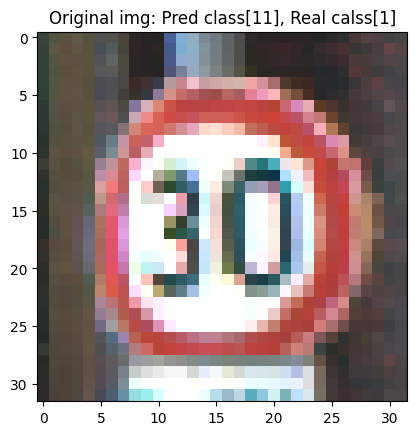

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


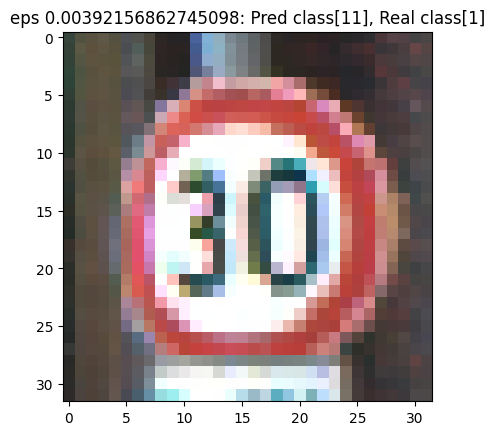

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


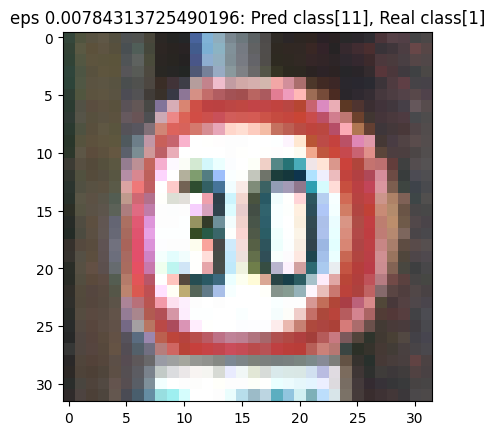

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


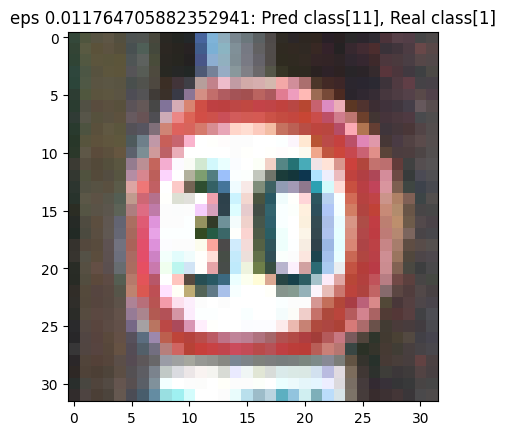

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


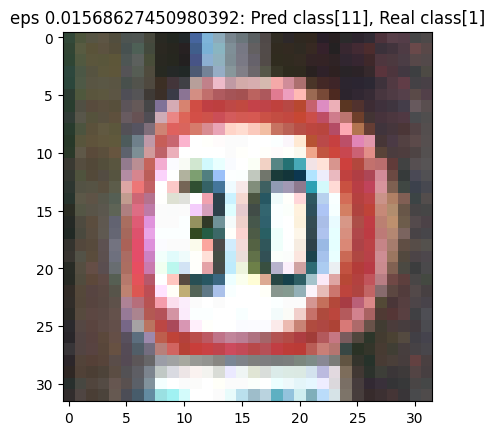

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


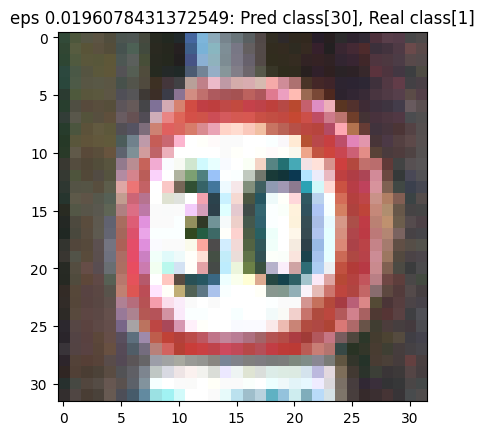

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


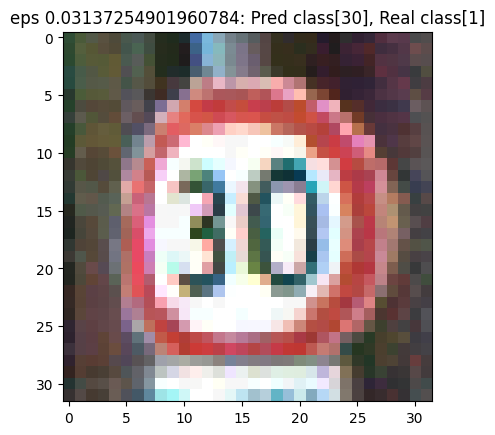

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


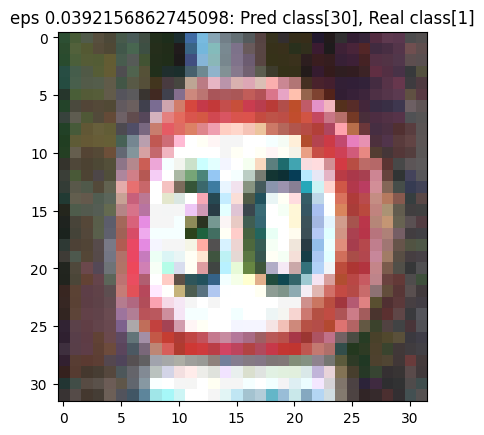

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


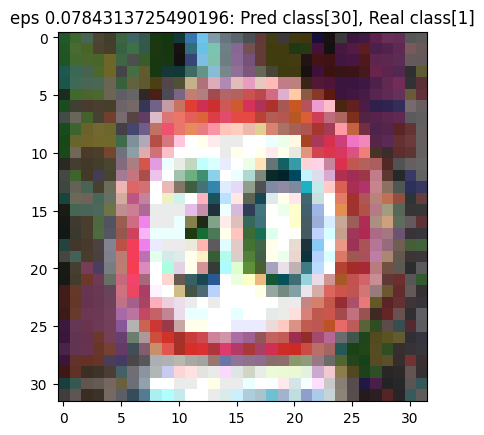

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


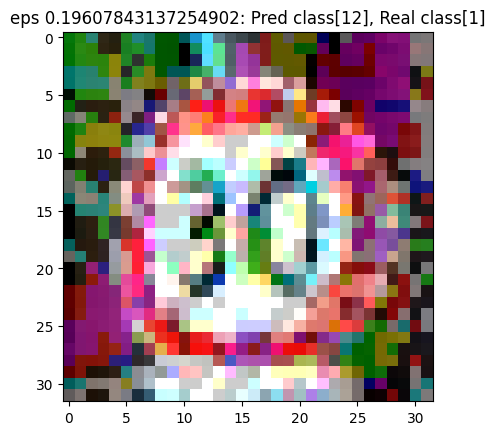

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


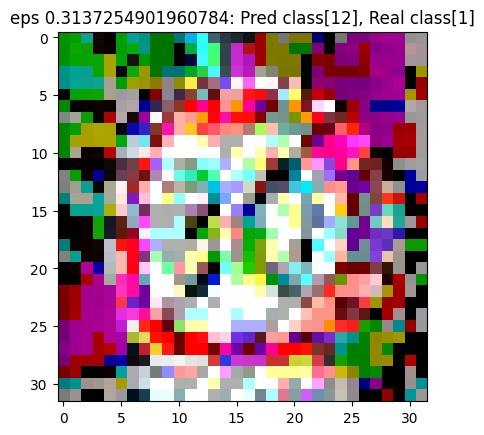

In [51]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(0)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[1])}]")
plt.imshow(x_test[1])
plt.show()
i = 1

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[1])}]")
    plt.imshow(x_test_adv[1])
    plt.show()
    i += 1

Реализация PGD атаки для ResNet50

In [52]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model=load_model('ResNet50.h5')
x_test = data[:1000]
y_test = y_test[:1000]
nb_classes = 1000
input_shape = (224, 224, 3)
classifier = TensorFlowV2Classifier(model=model, nb_classes=nb_classes, input_shape=input_shape, clip_values=(np.min(x_test), np.max(x_test)), loss_object=loss_object)


In [53]:
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_pgd = []
true_losses = []
adv_losses_pgd = []

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_pgd.append(accuracy)
    adv_losses_pgd.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.7432 - loss: 1.5529
Adv Loss: 1.5443538427352905
Adv Accuracy: 0.7289999723434448
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9039 - loss: 0.3704
True Loss: 0.37217968702316284
True Accuracy: 0.9070000052452087
Eps: 0.00784313725490196
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5789 - loss: 2.7782
Adv Loss: 2.8151257038116455
Adv Accuracy: 0.5630000233650208
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9039 - loss: 0.3704
True Loss: 0.37217968702316284
True Accuracy: 0.9070000052452087
Eps: 0.011764705882352941
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4835 - loss: 3.6526
Adv Loss: 3.719162702560425
Adv Accuracy: 0.47600001096725464
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9039 - loss: 0.3704
True Loss: 0.37217968702316284
True Accuracy: 0.9070000052452087
Eps: 0.01568627450980392
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4191 - loss: 4.2700
Ad

Сохраняем результаты

In [54]:
adv_losses_pgd = np.array(adv_losses_pgd)
adv_accuracises_pgd = np.array(adv_accuracises_pgd)
np.save("adv_losses_pgd_ResNet50", adv_losses_pgd)
np.save("adv_accuracises_pgd_ResNet50", adv_accuracises_pgd)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


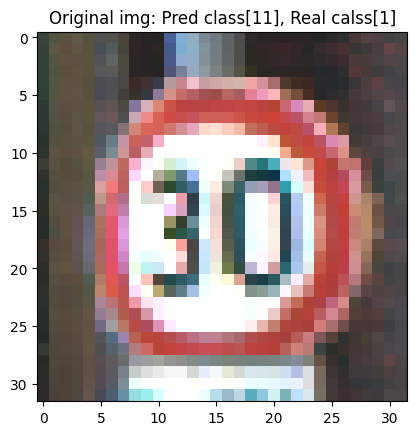

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


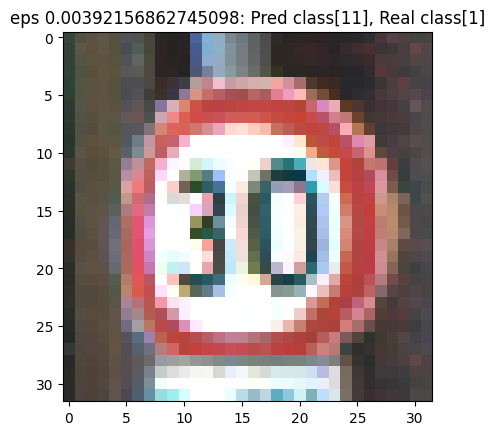

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


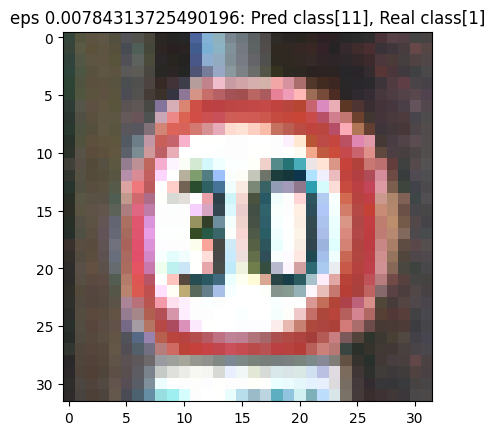

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


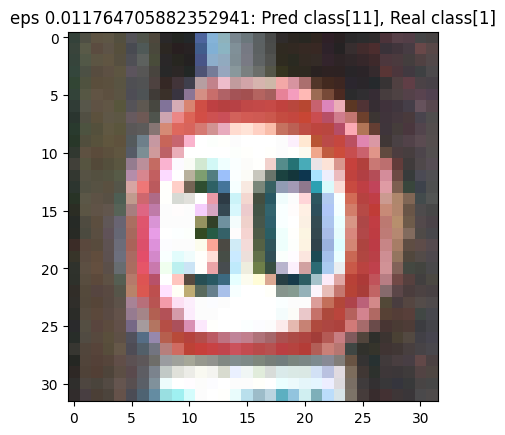

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


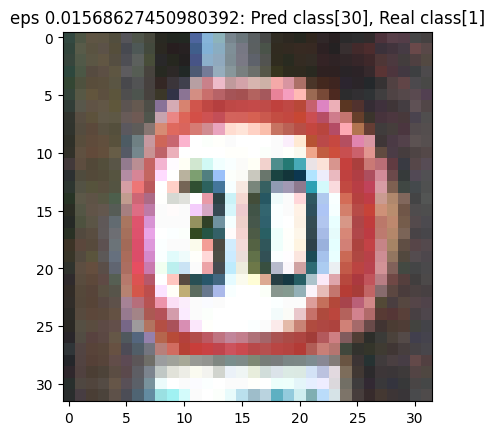

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


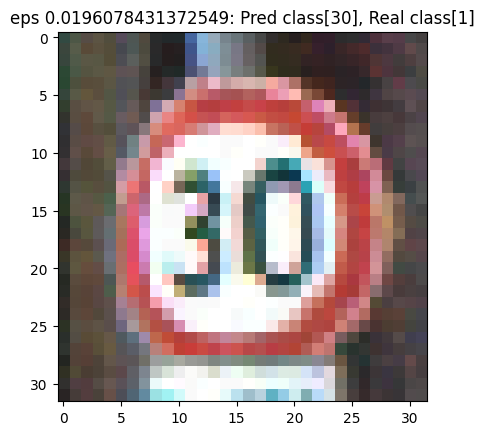

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


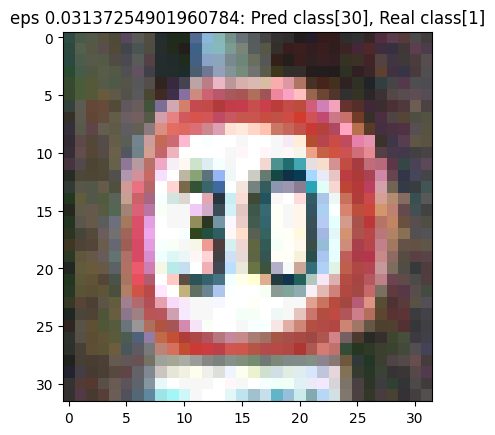

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


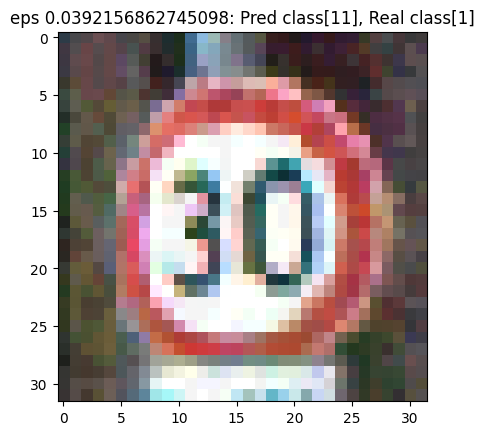

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


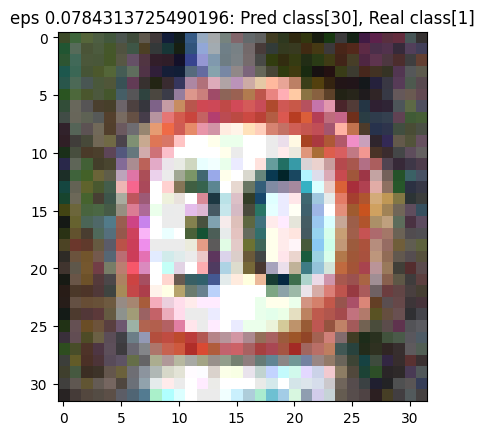

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


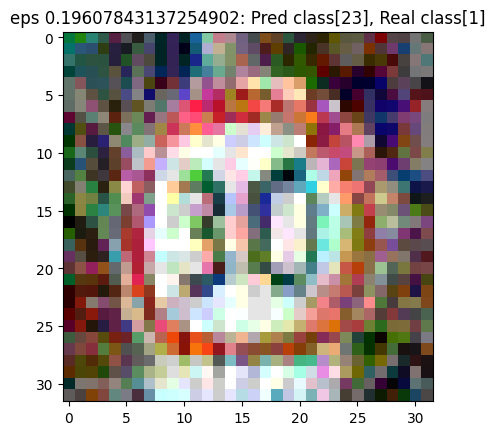

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


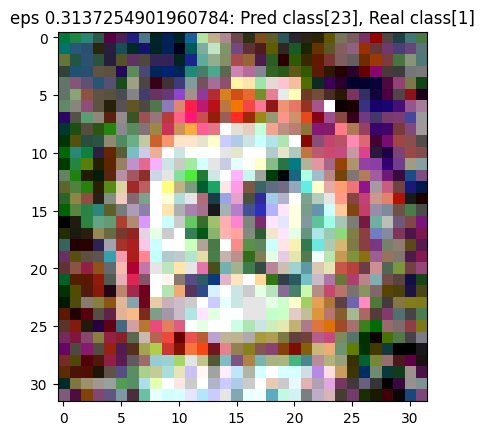

In [55]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(1)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[1])}]")
plt.imshow(x_test[1])
plt.show()
i = 1

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    x_test_adv = attack_pgd.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[1])}]")
    plt.imshow(x_test_adv[1])
    plt.show()
    i += 1

Визуализация графиков сравнения полученных результатов по модели ResNet50

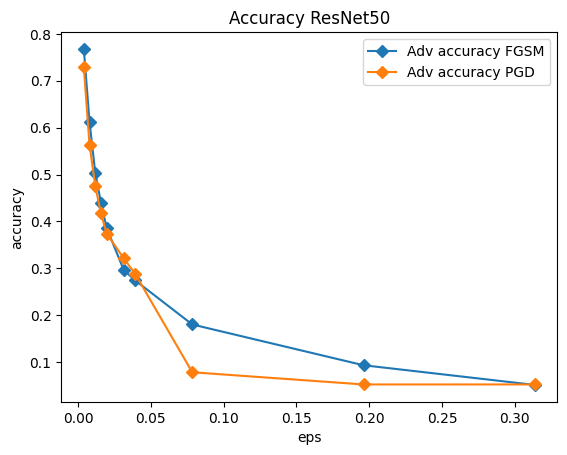

In [56]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
adv_accuracises_fgsm = np.load("adv_accuracises_fgsm_ResNet50.npy")
adv_accuracises_pgd = np.load("adv_accuracises_pgd_ResNet50.npy")
plt.figure(0)
plt.plot(eps_range, adv_accuracises_fgsm, label="Adv accuracy FGSM", marker='D')
plt.plot(eps_range, adv_accuracises_pgd, label="Adv accuracy PGD", marker='D')
plt.title("Accuracy ResNet50")
plt.xlabel("eps")
plt.ylabel("accuracy")
plt.legend()
plt.show()

Работа с моделью VGG16

In [57]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model=load_model('VGG16.h5')
x_test = data[:1000]
y_test = y_test[:1000]
nb_classes = 1000
input_shape = (224, 224, 3)
classifier = TensorFlowV2Classifier(model=model, nb_classes=nb_classes, input_shape=input_shape, clip_values=(np.min(x_test), np.max(x_test)), loss_object=loss_object)


Атака FGSM

In [58]:
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.3)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_fgsm = []
true_losses = []
adv_losses_fgsm = []

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_fgsm.append(accuracy)
    adv_losses_fgsm.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8575 - loss: 0.7545
Adv Loss: 0.7218955755233765
Adv Accuracy: 0.8519999980926514
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9365 - loss: 0.2469
True Loss: 0.23212875425815582
True Accuracy: 0.9430000185966492
Eps: 0.00784313725490196
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7603 - loss: 1.2603
Adv Loss: 1.2855647802352905
Adv Accuracy: 0.7519999742507935
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9365 - loss: 0.2469
True Loss: 0.23212875425815582
True Accuracy: 0.9430000185966492
Eps: 0.011764705882352941
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6862 - loss: 1.7520
Adv Loss: 1.8198364973068237
Adv Accuracy: 0.6769999861717224
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9365 - loss: 0.2469
True Loss: 0.23212875425815582
True Accuracy: 0.9430000185966492
Eps: 0.01568627450980392
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6385 - loss: 2.1646
Adv Lo

In [59]:
adv_losses_fgsm = np.array(adv_losses_fgsm)
adv_accuracises_fgsm = np.array(adv_accuracises_fgsm)
np.save("adv_losses_fgsm_VGG16", adv_losses_fgsm)
np.save("adv_accuracises_fgsm_VGG16", adv_accuracises_fgsm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


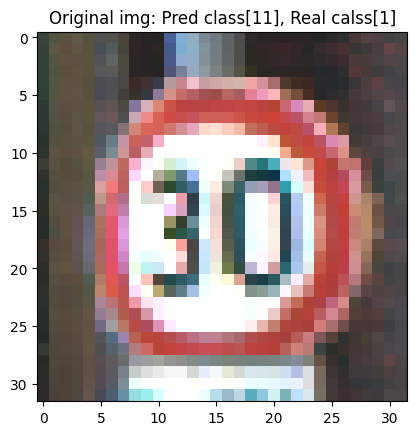

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


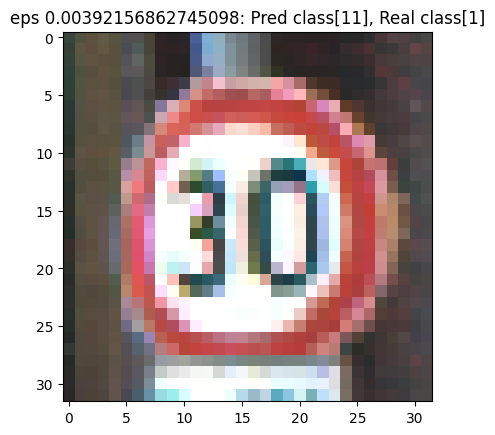

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


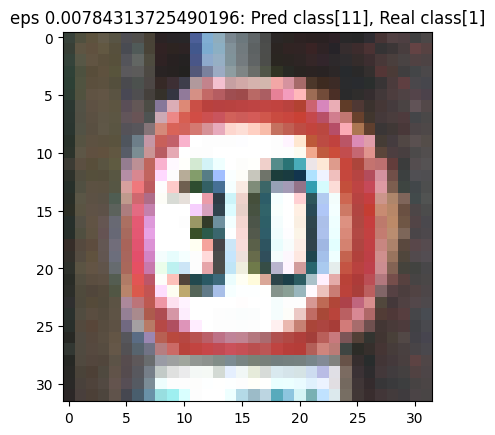

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


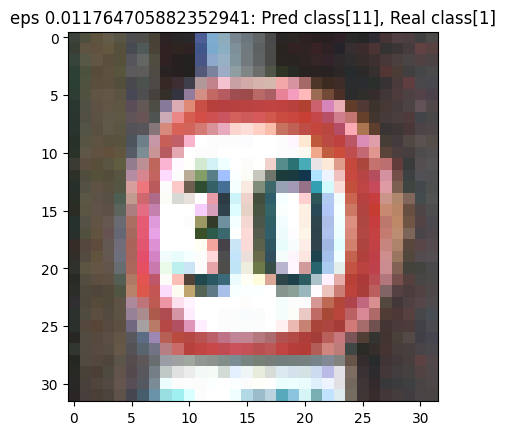

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


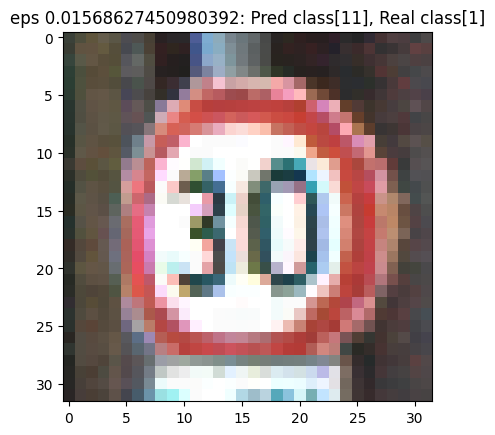

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


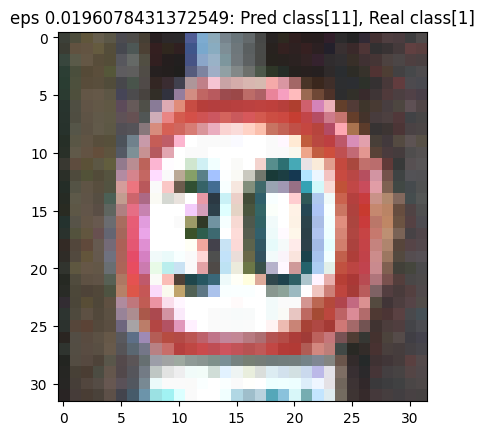

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


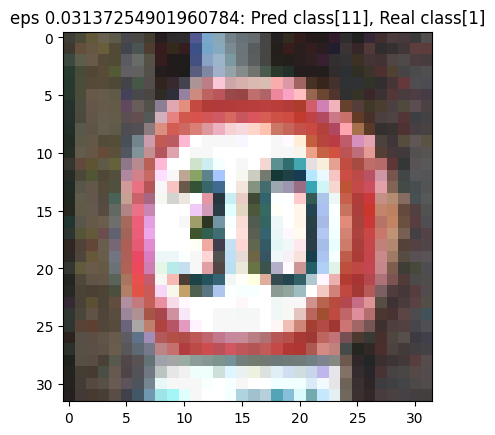

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


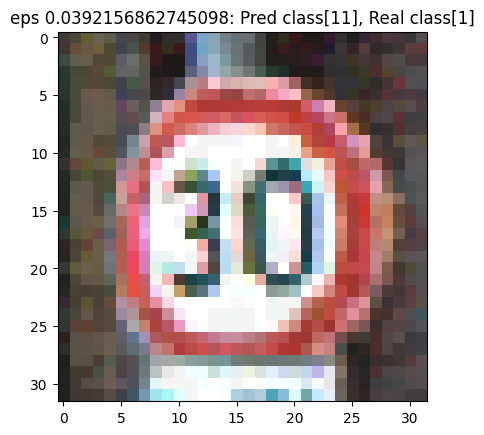

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


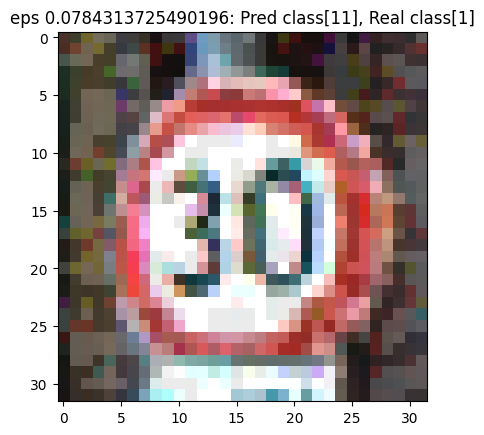

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


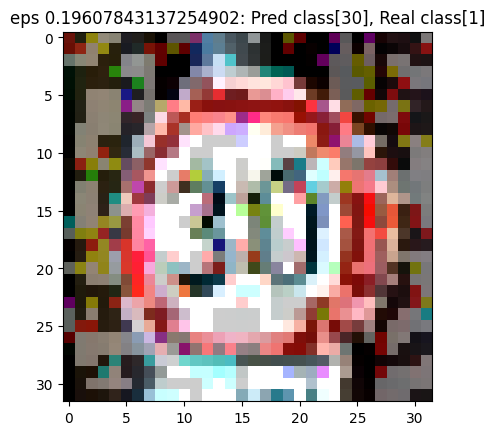

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


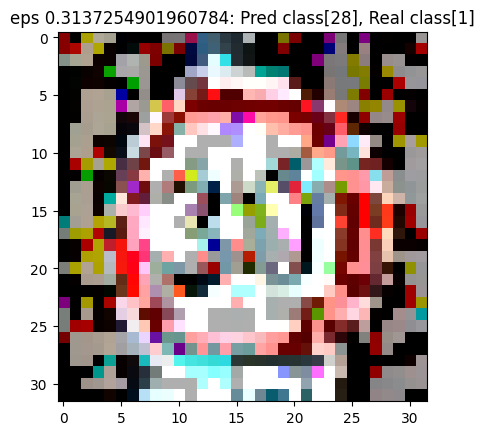

In [60]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(0)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[1])}]")
plt.imshow(x_test[1])
plt.show()
i = 1

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[1])}]")
    plt.imshow(x_test_adv[1])
    plt.show()
    i += 1

Атака PGD

In [61]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model=load_model('VGG16.h5')
x_test = data[:1000]
y_test = y_test[:1000]
nb_classes = 1000
input_shape = (224, 224, 3)
classifier = TensorFlowV2Classifier(model=model, nb_classes=nb_classes, input_shape=input_shape, clip_values=(np.min(x_test), np.max(x_test)), loss_object=loss_object)

In [62]:
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_pgd = []
true_losses = []
adv_losses_pgd = []

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_pgd.append(accuracy)
    adv_losses_pgd.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8506 - loss: 0.8077
Adv Loss: 0.8014605641365051
Adv Accuracy: 0.8450000286102295
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9365 - loss: 0.2469
True Loss: 0.23212875425815582
True Accuracy: 0.9430000185966492
Eps: 0.00784313725490196
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7586 - loss: 1.4155
Adv Loss: 1.5434831380844116
Adv Accuracy: 0.7400000095367432
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9365 - loss: 0.2469
True Loss: 0.23212875425815582
True Accuracy: 0.9430000185966492
Eps: 0.011764705882352941
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6863 - loss: 1.9798
Adv Loss: 2.0819079875946045
Adv Accuracy: 0.6729999780654907
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9365 - loss: 0.2469
True Loss: 0.23212875425815582
True Accuracy: 0.9430000185966492
Eps: 0.01568627450980392
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6649 - loss: 2.2900
Adv Lo

In [63]:
adv_losses_pgd = np.array(adv_losses_pgd)
adv_accuracises_pgd = np.array(adv_accuracises_pgd)
np.save("adv_losses_pgd_VGG16", adv_losses_pgd)
np.save("adv_accuracises_pgd_VGG16", adv_accuracises_pgd)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


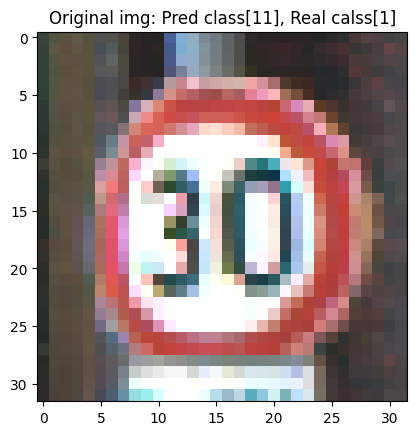

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


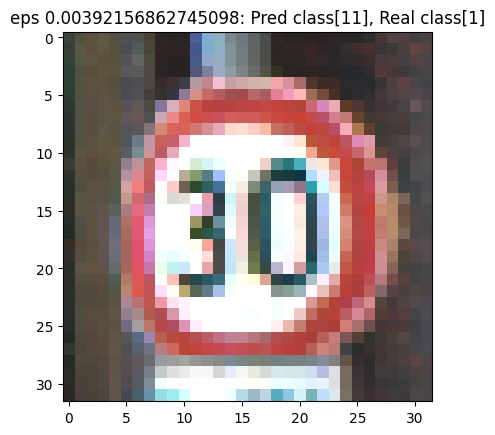

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


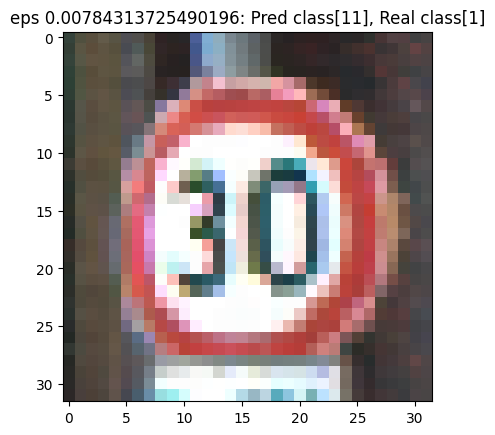

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


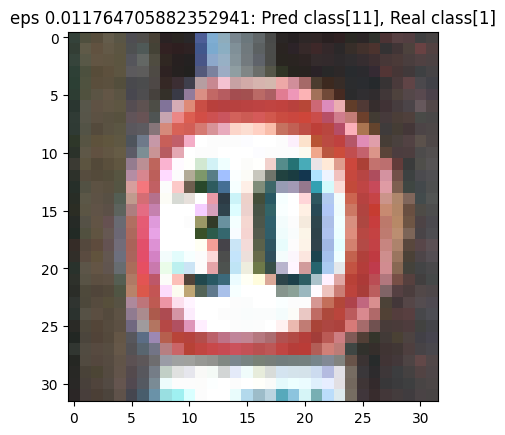

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


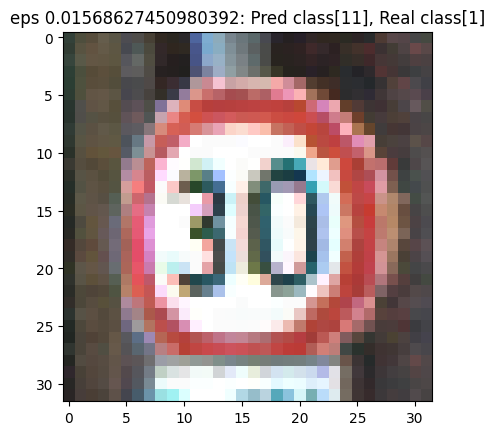

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


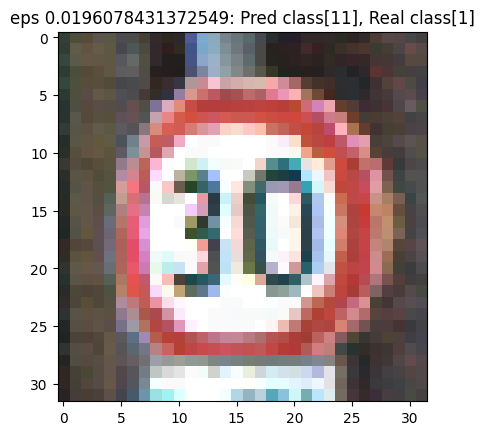

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


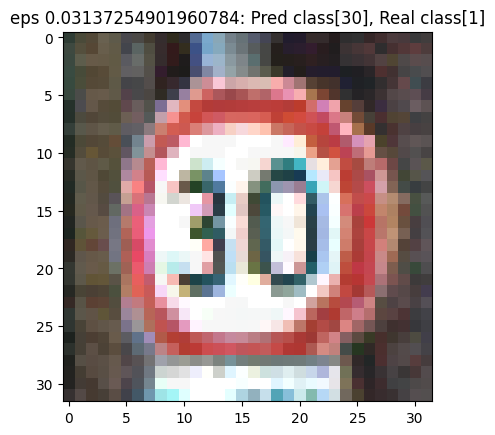

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


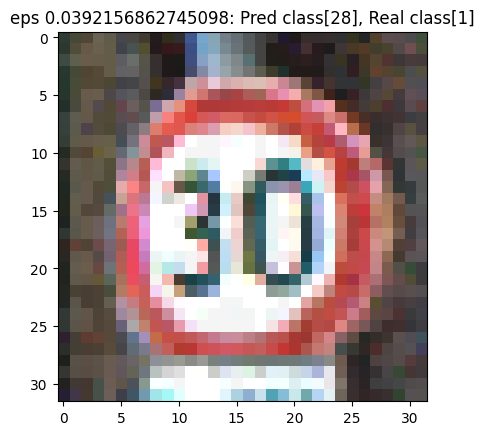

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


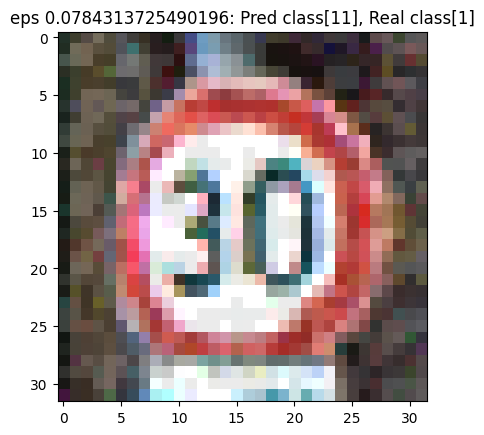

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


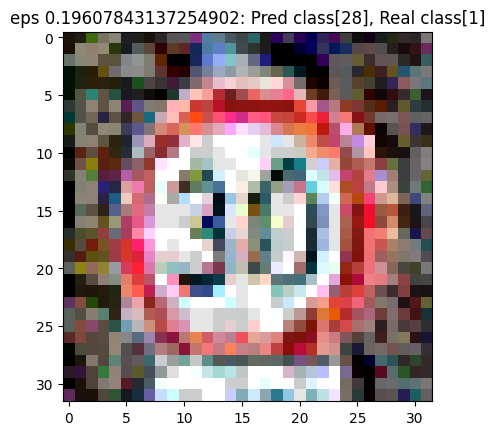

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


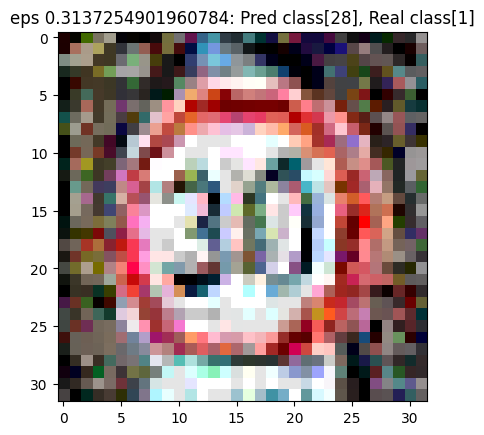

In [64]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(0)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[1])}]")
plt.imshow(x_test[1])
plt.show()
i = 1

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    x_test_adv = attack_pgd.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[1])}]")
    plt.imshow(x_test_adv[1])
    plt.show()
    i += 1

Визуализация модели VGG16

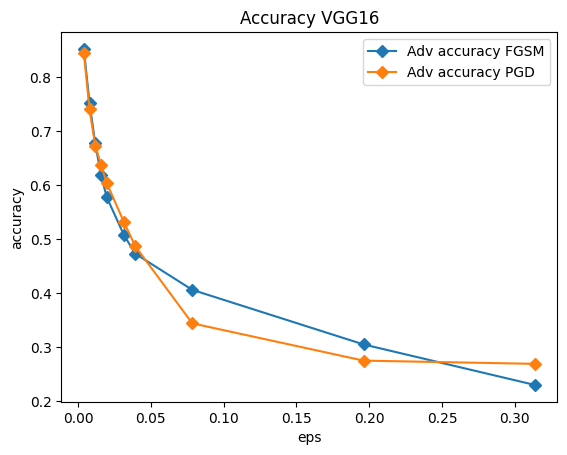

In [65]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
adv_accuracises_fgsm = np.load("adv_accuracises_fgsm_VGG16.npy")
adv_accuracises_pgd = np.load("adv_accuracises_pgd_VGG16.npy")
plt.figure(0)
plt.plot(eps_range, adv_accuracises_fgsm, label="Adv accuracy FGSM", marker='D')
plt.plot(eps_range, adv_accuracises_pgd, label="Adv accuracy PGD", marker='D')
plt.title("Accuracy VGG16")
plt.xlabel("eps")
plt.ylabel("accuracy")
plt.legend()
plt.show()

Применение целевой атаки уклонения методов белого против моделей глубокого обучения

In [66]:
test = pd.read_csv("Test.csv")
test_imgs = test['Path'].values
data = []
y_test = []
labels = test['ClassId'].values.tolist()
i = -1

for img in test_imgs:
    i += 1
    if labels[i] != 14:
      continue
    img = image.load_img(img, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = img_array /255
    data.append(img_array)
    y_test.append(labels[i])
data = np.array(data)
y_test = np.array(y_test)
y_test = to_categorical(y_test, 43)

In [67]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model=load_model('ResNet50.h5')
t_class = 1
t_class = to_categorical(t_class, 43)
t_classes = np.tile(t_class, (270, 1))
x_test = data
nb_classes = 1000
input_shape = (224, 224, 3)
classifier = TensorFlowV2Classifier(model=model, nb_classes=nb_classes, input_shape=input_shape, clip_values=(np.min(x_test), np.max(x_test)), loss_object=loss_object)
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.2, targeted=True, batch_size=64)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
tar_accuracises_fgsm = []

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, t_classes)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    tar_accuracises_fgsm.append(accuracy)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 283ms/step - accuracy: 0.9284 - loss: 0.3379
Adv Loss: 0.30836448073387146
Adv Accuracy: 0.9259259104728699
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9944 - loss: 0.0433
True Loss: 0.05346432700753212
True Accuracy: 0.9925925731658936
Eps: 0.00784313725490196
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8260 - loss: 0.9945
Adv Loss: 1.0475038290023804
Adv Accuracy: 0.7962962985038757
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9944 - loss: 0.0433
True Loss: 0.05346432700753212
True Accuracy: 0.9925925731658936
Eps: 0.011764705882352941
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7208 - loss: 1.6578
Adv Loss: 1.7536154985427856
Adv Accuracy: 0.6962962746620178
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9944 - loss: 0.0433
True Loss: 0.05346432700753212
True Accuracy: 0.9925925731658936
Eps: 0.01568627450980392
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6052 - loss: 2.2277
Adv Loss: 2.3

In [68]:
tar_accuracises_fgsm = np.array(tar_accuracises_fgsm)
np.save("tar_accuracies_fgsm_ResNet50",tar_accuracises_fgsm)

In [69]:
eps = 10/255
attack_fgsm.set_params(**{'eps': eps})
x_test_adv = attack_fgsm.generate(x_test, t_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


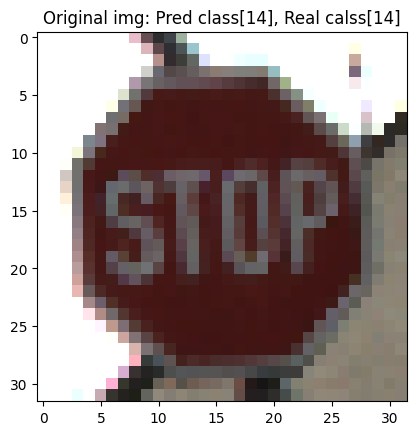

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


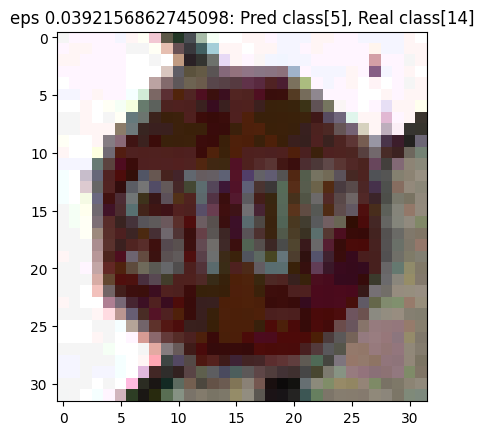

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


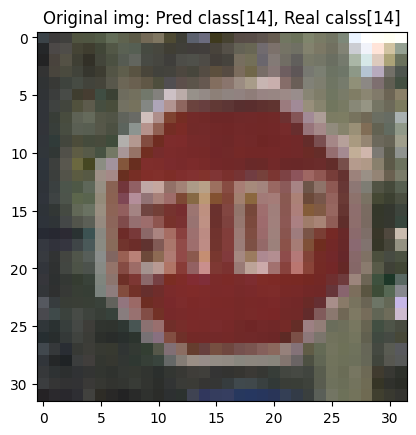

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


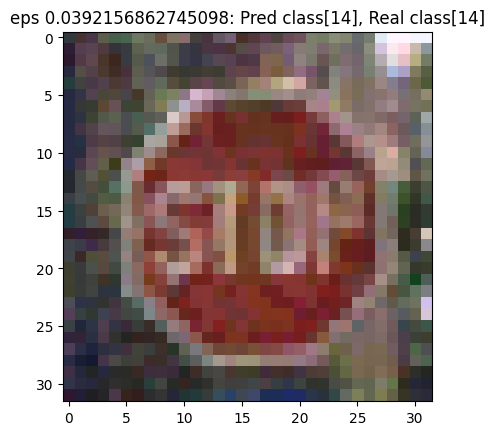

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


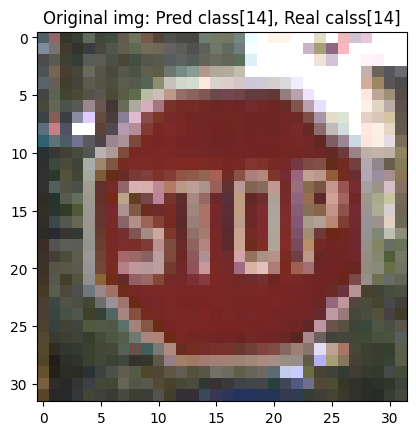

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


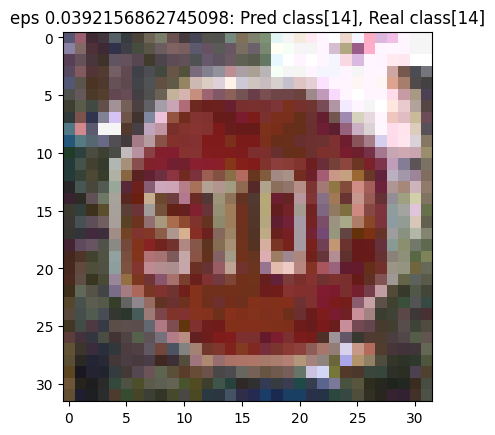

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


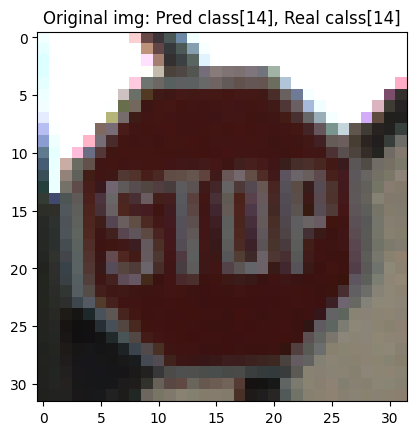

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


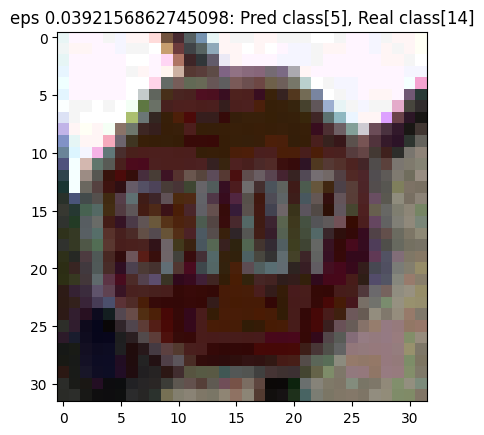

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


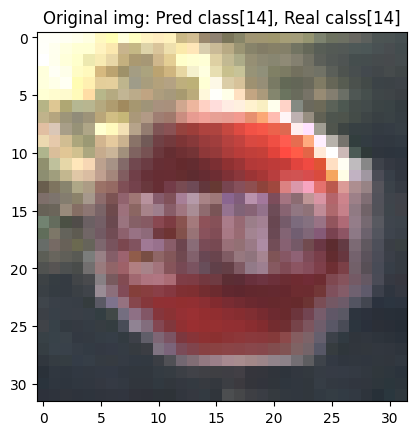

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


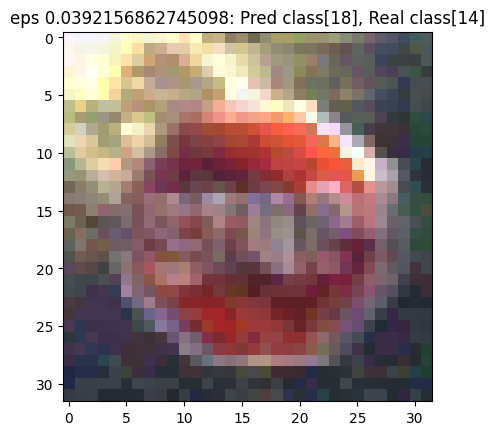

In [70]:
range = [0, 10, 20, 30, 40]
i = 0
for index in range:
  plt.figure(i)
  pred = np.argmax(model.predict(x_test[index:index+1]))
  plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[index])}]")
  plt.imshow(x_test[index])
  plt.show()
  i += 1
  pred = np.argmax(model.predict(x_test_adv[index:index+1]))
  plt.figure(i)
  plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[index])}]")
  plt.imshow(x_test_adv[index])
  plt.show()


Атака PGD

In [71]:

loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model=load_model('ResNet50.h5')
nb_classes = 1000
input_shape = (224, 224, 3)
classifier = TensorFlowV2Classifier(model=model, nb_classes=nb_classes, input_shape=input_shape, clip_values=(np.min(x_test), np.max(x_test)), loss_object=loss_object)
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False, targeted=True)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
tar_accuracises_pgd = []

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, t_classes)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    tar_accuracises_pgd.append(accuracy)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.9594 - loss: 0.1673
Adv Loss: 0.17596803605556488
Adv Accuracy: 0.9555555582046509
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9944 - loss: 0.0433
True Loss: 0.05346432700753212
True Accuracy: 0.9925925731658936
Eps: 0.00784313725490196
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8623 - loss: 0.6269
Adv Loss: 0.6761694550514221
Adv Accuracy: 0.855555534362793
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9944 - loss: 0.0433
True Loss: 0.05346432700753212
True Accuracy: 0.9925925731658936
Eps: 0.011764705882352941
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8593 - loss: 0.6429
Adv Loss: 0.7874593734741211
Adv Accuracy: 0.8296296000480652
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9944 - loss: 0.0433
True Loss: 0.05346432700753212
True Accuracy: 0.9925925731658936
Eps: 0.01568627450980392
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8107 - loss: 0.8612
Adv Loss: 0.9

In [72]:
tar_accuracises_pgd = np.array(tar_accuracises_pgd)
np.save("tar_accuracies_pgd_ResNet50",tar_accuracises_pgd)

In [73]:
eps = 10/255
attack_pgd.set_params(**{'eps': eps})
x_test_adv = attack_pgd.generate(x_test, t_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


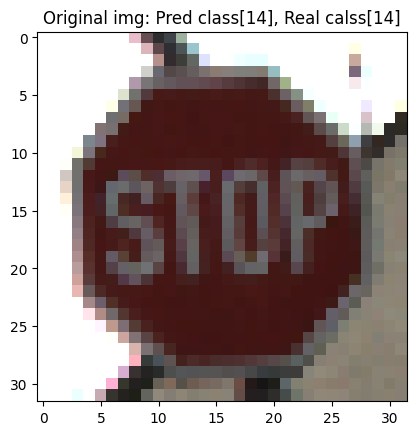

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


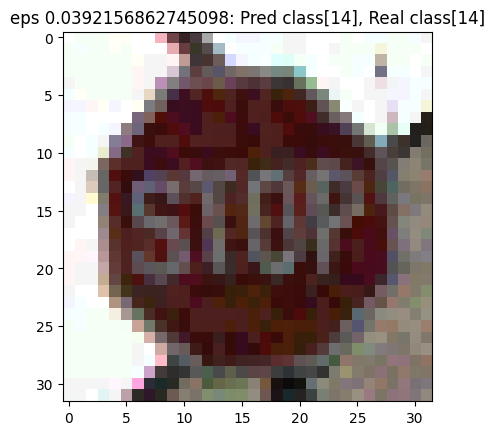

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


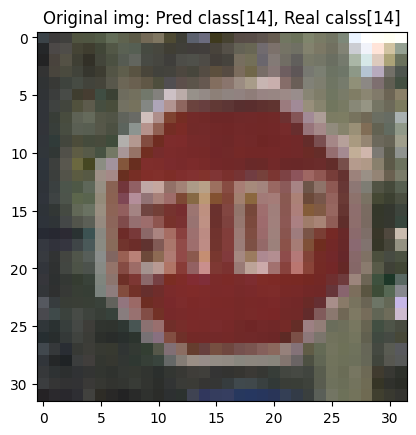

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


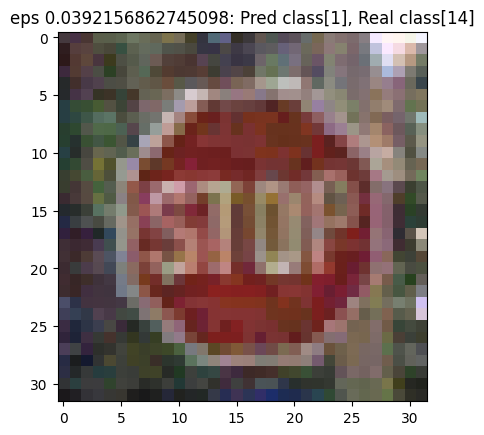

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


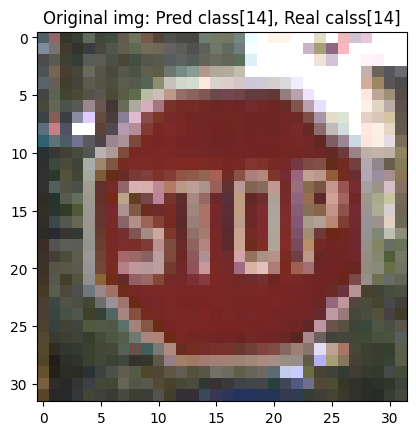

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


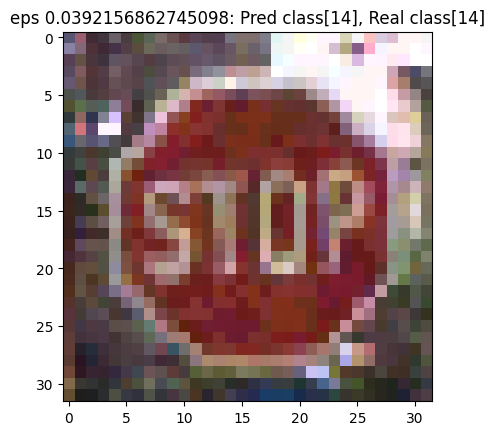

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


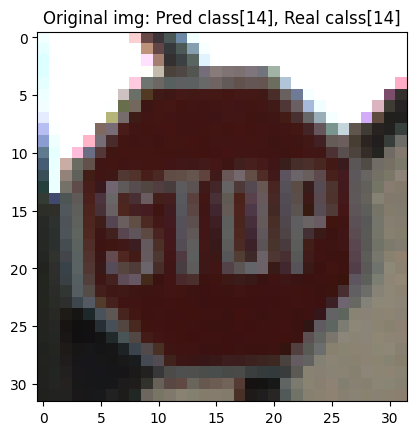

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


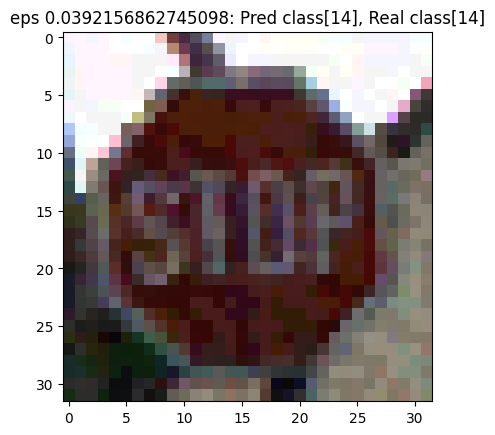

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


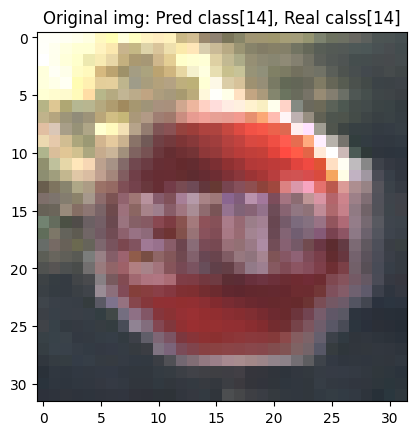

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


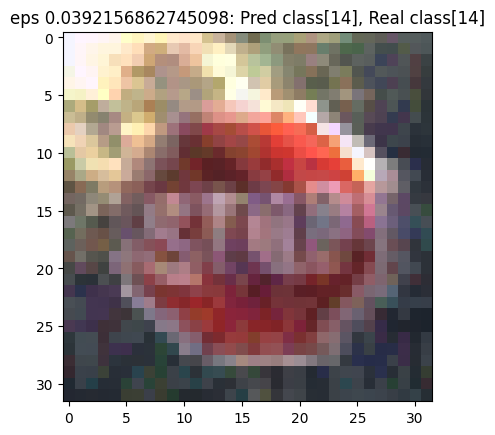

In [74]:
range = [0, 10, 20, 30, 40]
i = 0
for index in range:
  plt.figure(i)
  pred = np.argmax(model.predict(x_test[index:index+1]))
  plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[index])}]")
  plt.imshow(x_test[index])
  plt.show()
  i += 1
  pred = np.argmax(model.predict(x_test_adv[index:index+1]))
  plt.figure(i)
  plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[index])}]")
  plt.imshow(x_test_adv[index])
  plt.show()

In [75]:
eps_values_acc = ["1/255", "2/255", "3/255", "4/255", "5/255", "8/255", "10/255", "20/255", "50/255", "80/255"]
tar_acc_fgsm_rn50 = np.load("tar_accuracies_fgsm_ResNet50.npy")
tar_acc_pdp_rn50 = np.load("tar_accuracies_pgd_ResNet50.npy")

table = [["Искажение","FGSM","PGD"],
            [eps_values_acc[0],tar_acc_fgsm_rn50[0],tar_acc_pdp_rn50[0]],
            [eps_values_acc[1],tar_acc_fgsm_rn50[1],tar_acc_pdp_rn50[1]],
            [eps_values_acc[2],tar_acc_fgsm_rn50[2],tar_acc_pdp_rn50[2]],
            [eps_values_acc[3],tar_acc_fgsm_rn50[3],tar_acc_pdp_rn50[3]],
            [eps_values_acc[4],tar_acc_fgsm_rn50[4],tar_acc_pdp_rn50[4]],
            [eps_values_acc[5],tar_acc_fgsm_rn50[5],tar_acc_pdp_rn50[5]],
            [eps_values_acc[6],tar_acc_fgsm_rn50[6],tar_acc_pdp_rn50[6]],
            [eps_values_acc[7],tar_acc_fgsm_rn50[7],tar_acc_pdp_rn50[7]],
            [eps_values_acc[8],tar_acc_fgsm_rn50[8],tar_acc_pdp_rn50[8]],
            [eps_values_acc[9],tar_acc_fgsm_rn50[9],tar_acc_pdp_rn50[9]],
         ]

table2 = tabulate(table,headers="firstrow",tablefmt="grid")
print(table2)

+-------------+------------+-----------+
| Искажение   |       FGSM |       PGD |
+=============+============+===========+
| 1/255       | 0.925926   | 0.955556  |
+-------------+------------+-----------+
| 2/255       | 0.796296   | 0.855556  |
+-------------+------------+-----------+
| 3/255       | 0.696296   | 0.82963   |
+-------------+------------+-----------+
| 4/255       | 0.566667   | 0.788889  |
+-------------+------------+-----------+
| 5/255       | 0.477778   | 0.744444  |
+-------------+------------+-----------+
| 8/255       | 0.225926   | 0.637037  |
+-------------+------------+-----------+
| 10/255      | 0.140741   | 0.703704  |
+-------------+------------+-----------+
| 20/255      | 0.0185185  | 0.32963   |
+-------------+------------+-----------+
| 50/255      | 0.0037037  | 0.0259259 |
+-------------+------------+-----------+
| 80/255      | 0.00740741 | 0.0037037 |
+-------------+------------+-----------+
